In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [3]:
df = pd.read_csv('tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
df.shape

(40000, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [6]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop('tweet_id', axis=1, inplace=True)

In [9]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

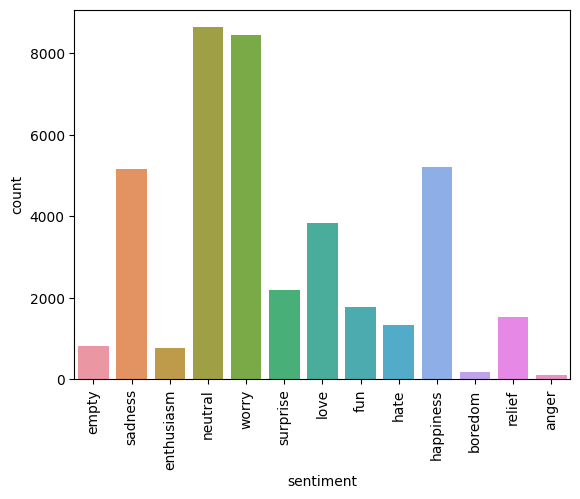

In [10]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

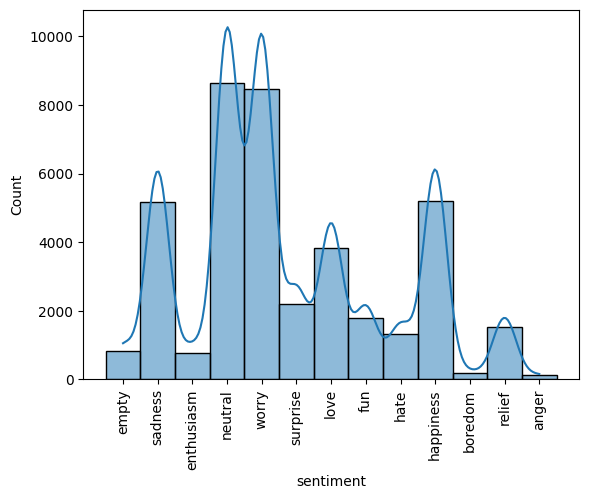

In [11]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/cfm5qc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cfm5qc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cfm5qc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cfm5qc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [14]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

    ## Next step is text-normalization

    # Text normalization includes many steps.

    # Each function below serves a step.


    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words


    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words


    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words


    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems


    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas


    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # All above functions work on word tokens we need a tokenizer

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)


    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text

    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]


    # return processed df
    return df

In [15]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [16]:
df.head()

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin n bed headache ughhhh waitin call
2,sadness,funeral ceremony gloomy friday
3,enthusiasm,want hang friends soon
4,neutral,dannycastillo want trade someone houston ticke...


In [17]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [18]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    elif row['sentiment'] in ['neutral','relief','surprise','enthusiasm', 'happiness', 'love', 'fun']:  # Note: 'empty' appears again; check if this is correct.
        return 'Neutral'
    #elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun']:
    #    return 'Positive'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)

In [19]:
#df.rename(columns={'sentiment': 'category'}, inplace=True)

In [20]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Neutral
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Neutral
39997,love,happy mother day mommies woman man long momma ...,Neutral
39998,happiness,niariley wassup beautiful follow peep new hit ...,Neutral


# Balance data

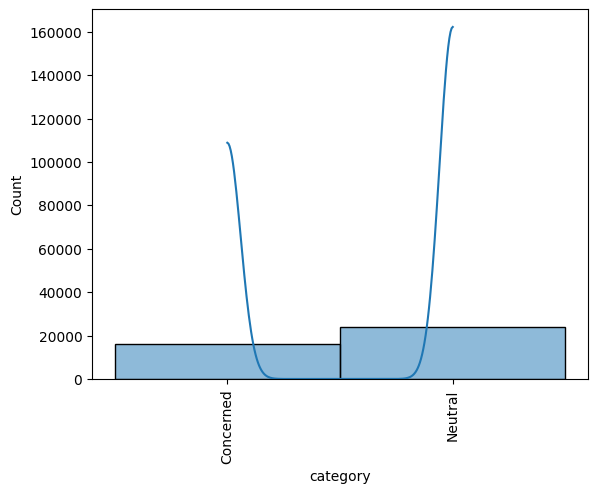

In [21]:
sns.histplot(x=df['category'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [22]:
df['category'].value_counts()

Neutral      23937
Concerned    16063
Name: category, dtype: int64

In [23]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Neutral
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Neutral
39997,love,happy mother day mommies woman man long momma ...,Neutral
39998,happiness,niariley wassup beautiful follow peep new hit ...,Neutral


In [24]:
label_mapping = {'Neutral': 0, 'Concerned': 1}#, 'Concerned':2}, 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)


In [25]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [26]:
train_df

,sentiment,content,category
38015,sadness,ficklampa hehe option advertise world mess mig...,1
2281,boredom,wake day need go work suck also go dentist fil...,1
36629,neutral,ilhongy would get,0
6087,worry,penbleth leave forever miss much,1
11792,neutral,lt train today ehhh hard tall hard feel good s...,0
...,...,...,...
6265,neutral,clean,0
11284,hate,ooo goddddd vodafone trouble network,1
38158,fun,watch run fat boy run haha soo funny,0
860,hate,calvinharris make pork products fuck stop impo...,1


In [27]:
X_train = train_df['content'].values
y_train = train_df['category'].values

X = test_df['content'].values
y = test_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 28000; y_test: 9000; y_valid: 3000


In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [30]:
labels = df['category'].unique()


In [31]:
from transformers import XLNetForSequenceClassification
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn

In [32]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    elif row['sentiment'] in ['neutral']:  # Note: 'empty' appears again; check if this is correct.
        return 'Neutral'
    elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun','relief','surprise']:
        return 'Positive'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)


In [33]:
label_mapping = {'Neutral': 0, 'Concerned': 1, 'Positive':2}# 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)

In [34]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [35]:
X = test_df['content'].values
y = test_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 56000; y_test: 9000; y_valid: 3000


In [37]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [38]:
labels = df['category'].unique()

In [39]:
def plot_loss_over_epochs(train_losses, val_losses):

    if len(train_losses) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(train_losses) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': train_losses,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Hyperparameters

## Batch Size

### 64 Batch Size and 1e-4

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 438/438 [00:41<00:00, 10.51it/s]


Training Loss: 1.0897


Validation: 100%|██████████| 47/47 [00:02<00:00, 22.48it/s]


Validation Loss: 1.0808
Epoch 2/10


Training: 100%|██████████| 438/438 [00:39<00:00, 11.08it/s]


Training Loss: 1.0782


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.84it/s]


Validation Loss: 1.0684
Epoch 3/10


Training: 100%|██████████| 438/438 [00:37<00:00, 11.58it/s]


Training Loss: 1.0773


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.15it/s]


Validation Loss: 1.0747
Epoch 4/10


Training: 100%|██████████| 438/438 [00:41<00:00, 10.62it/s]


Training Loss: 1.0754


Validation: 100%|██████████| 47/47 [00:01<00:00, 46.17it/s]


Validation Loss: 1.0710
Epoch 5/10


Training: 100%|██████████| 438/438 [00:36<00:00, 12.16it/s]


Training Loss: 1.0736


Validation: 100%|██████████| 47/47 [00:01<00:00, 30.69it/s]


Validation Loss: 1.0717
Epoch 6/10


Training: 100%|██████████| 438/438 [00:36<00:00, 11.94it/s]


Training Loss: 1.0720


Validation: 100%|██████████| 47/47 [00:01<00:00, 24.97it/s]


Validation Loss: 1.0657
Epoch 7/10


Training: 100%|██████████| 438/438 [00:37<00:00, 11.72it/s]


Training Loss: 1.0715


Validation: 100%|██████████| 47/47 [00:04<00:00, 11.71it/s]


Validation Loss: 1.0637
Epoch 8/10


Training: 100%|██████████| 438/438 [00:35<00:00, 12.38it/s]


Training Loss: 1.0704


Validation: 100%|██████████| 47/47 [00:01<00:00, 38.40it/s]


Validation Loss: 1.0664
Epoch 9/10


Training: 100%|██████████| 438/438 [00:34<00:00, 12.58it/s]


Training Loss: 1.0700


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.79it/s]


Validation Loss: 1.0655
Epoch 10/10


Training: 100%|██████████| 438/438 [00:39<00:00, 11.16it/s]


Training Loss: 1.0689


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.29it/s]


Validation Loss: 1.0646
Validation Set Evaluation:
Confusion Matrix:
[[   0  638    0]
 [   0 1194    0]
 [   0 1168    0]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       638
   Concerned       0.40      1.00      0.57      1194
    Positive       0.00      0.00      0.00      1168

    accuracy                           0.40      3000
   macro avg       0.13      0.33      0.19      3000
weighted avg       0.16      0.40      0.23      3000



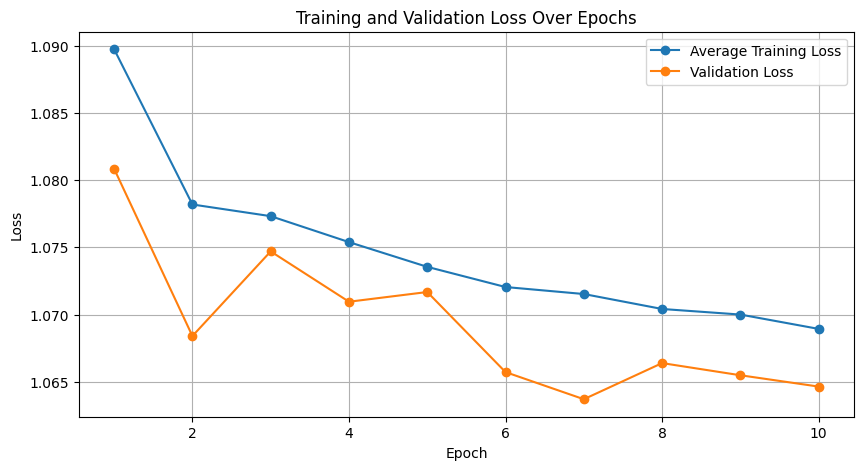

In [40]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)
is_train=True
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss
# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

plot_loss_over_epochs(training_loss, validation_loss)

### 64 Batch Size and 1e-6

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 438/438 [00:38<00:00, 11.43it/s]


Training Loss: 1.1234


Validation: 100%|██████████| 47/47 [00:01<00:00, 27.34it/s]


Validation Loss: 1.0432
Epoch 2/10


Training: 100%|██████████| 438/438 [00:38<00:00, 11.50it/s]


Training Loss: 1.0056


Validation: 100%|██████████| 47/47 [00:01<00:00, 46.62it/s]


Validation Loss: 0.9479
Epoch 3/10


Training: 100%|██████████| 438/438 [00:40<00:00, 10.78it/s]


Training Loss: 0.9440


Validation: 100%|██████████| 47/47 [00:02<00:00, 21.79it/s]


Validation Loss: 0.9397
Epoch 4/10


Training: 100%|██████████| 438/438 [00:41<00:00, 10.67it/s]


Training Loss: 0.9210


Validation: 100%|██████████| 47/47 [00:02<00:00, 18.30it/s]


Validation Loss: 0.9288
Epoch 5/10


Training: 100%|██████████| 438/438 [00:42<00:00, 10.33it/s]


Training Loss: 0.9055


Validation: 100%|██████████| 47/47 [00:01<00:00, 41.26it/s]


Validation Loss: 0.9349
Epoch 6/10


Training: 100%|██████████| 438/438 [00:41<00:00, 10.65it/s]


Training Loss: 0.8973


Validation: 100%|██████████| 47/47 [00:03<00:00, 14.02it/s]


Validation Loss: 0.9020
Epoch 7/10


Training: 100%|██████████| 438/438 [00:37<00:00, 11.77it/s]


Training Loss: 0.8907


Validation: 100%|██████████| 47/47 [00:01<00:00, 25.52it/s]


Validation Loss: 0.9182
Epoch 8/10


Training: 100%|██████████| 438/438 [00:39<00:00, 11.21it/s]


Training Loss: 0.8858


Validation: 100%|██████████| 47/47 [00:03<00:00, 13.84it/s]


Validation Loss: 0.9019
Epoch 9/10


Training: 100%|██████████| 438/438 [00:41<00:00, 10.46it/s]


Training Loss: 0.8774


Validation: 100%|██████████| 47/47 [00:03<00:00, 12.36it/s]


Validation Loss: 0.9143
Epoch 10/10


Training: 100%|██████████| 438/438 [00:39<00:00, 10.96it/s]


Training Loss: 0.8719


Validation: 100%|██████████| 47/47 [00:01<00:00, 41.72it/s]


Validation Loss: 0.9083
Validation Set Evaluation:
Confusion Matrix:
[[136 268 234]
 [ 82 850 262]
 [ 73 283 812]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.47      0.21      0.29       638
   Concerned       0.61      0.71      0.66      1194
    Positive       0.62      0.70      0.66      1168

    accuracy                           0.60      3000
   macro avg       0.56      0.54      0.53      3000
weighted avg       0.58      0.60      0.58      3000



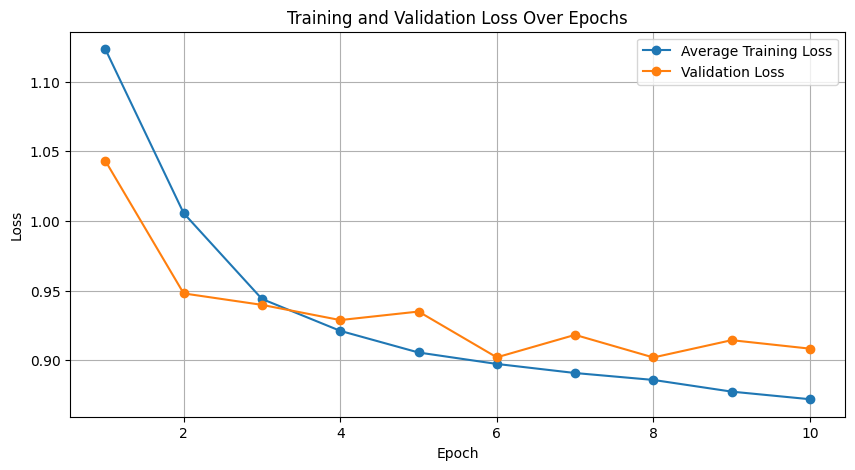

In [41]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)
is_train=True
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss
# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

plot_loss_over_epochs(training_loss, validation_loss)

### 64 Batch Size and 1e-8

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 438/438 [00:42<00:00, 10.33it/s]


Training Loss: 1.7821


Validation: 100%|██████████| 47/47 [00:01<00:00, 38.58it/s]


Validation Loss: 1.7029
Epoch 2/10


Training: 100%|██████████| 438/438 [00:40<00:00, 10.71it/s]


Training Loss: 1.6680


Validation: 100%|██████████| 47/47 [00:03<00:00, 15.12it/s]


Validation Loss: 1.5648
Epoch 3/10


Training: 100%|██████████| 438/438 [00:40<00:00, 10.82it/s]


Training Loss: 1.5511


Validation: 100%|██████████| 47/47 [00:01<00:00, 43.68it/s]


Validation Loss: 1.4221
Epoch 4/10


Training: 100%|██████████| 438/438 [00:40<00:00, 10.69it/s]


Training Loss: 1.4298


Validation: 100%|██████████| 47/47 [00:01<00:00, 39.32it/s]


Validation Loss: 1.3060
Epoch 5/10


Training: 100%|██████████| 438/438 [00:40<00:00, 10.95it/s]


Training Loss: 1.3451


Validation: 100%|██████████| 47/47 [00:02<00:00, 17.28it/s]


Validation Loss: 1.2388
Epoch 6/10


Training: 100%|██████████| 438/438 [00:38<00:00, 11.47it/s]


Training Loss: 1.2919


Validation: 100%|██████████| 47/47 [00:01<00:00, 43.39it/s]


Validation Loss: 1.2022
Epoch 7/10


Training: 100%|██████████| 438/438 [00:38<00:00, 11.42it/s]


Training Loss: 1.2560


Validation: 100%|██████████| 47/47 [00:01<00:00, 29.38it/s]


Validation Loss: 1.1793
Epoch 8/10


Training: 100%|██████████| 438/438 [00:43<00:00, 10.17it/s]


Training Loss: 1.2317


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.98it/s]


Validation Loss: 1.1634
Epoch 9/10


Training: 100%|██████████| 438/438 [00:39<00:00, 10.96it/s]


Training Loss: 1.2145


Validation: 100%|██████████| 47/47 [00:01<00:00, 26.01it/s]


Validation Loss: 1.1508
Epoch 10/10


Training: 100%|██████████| 438/438 [00:42<00:00, 10.36it/s]


Training Loss: 1.1982


Validation: 100%|██████████| 47/47 [00:01<00:00, 34.37it/s]


Validation Loss: 1.1409
Validation Set Evaluation:
Confusion Matrix:
[[  0 155 483]
 [  0 320 874]
 [  0 246 922]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       638
   Concerned       0.44      0.27      0.33      1194
    Positive       0.40      0.79      0.53      1168

    accuracy                           0.41      3000
   macro avg       0.28      0.35      0.29      3000
weighted avg       0.33      0.41      0.34      3000



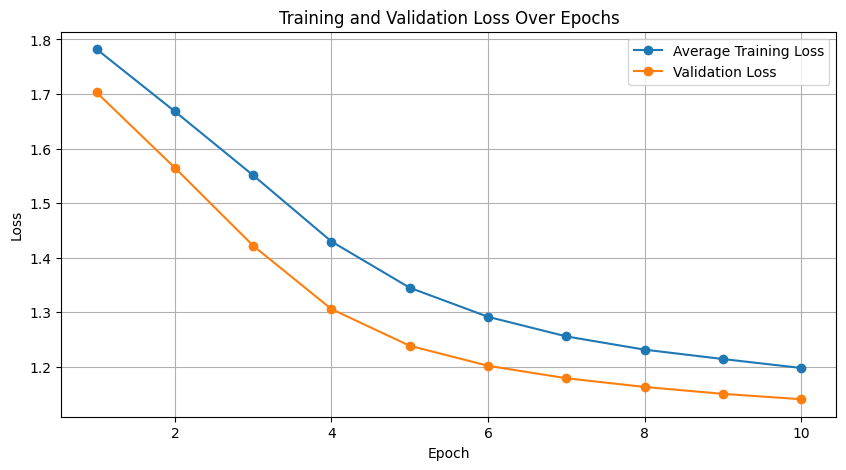

In [42]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)
is_train=True
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss
# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

plot_loss_over_epochs(training_loss, validation_loss)